<img src="images/dask_horizontal.svg" align="right" width="30%">

# Bag: Parallel Lists for semi-structured data

Dask-bag excels in processing data that can be represented as a sequence of arbitrary inputs. We'll refer to this as "messy" data, because it can contain complex nested structures, missing fields, mixtures of data types, etc. The *functional* programming style fits very nicely with standard Python iteration, such as can be found in the `itertools` module.

Messy data is often encountered at the beginning of data processing pipelines when large volumes of raw data are first consumed. The initial set of data might be JSON, CSV, XML, or any other format that does not enforce strict structure and datatypes.
For this reason, the initial data massaging and processing is often done with Python `list`s, `dict`s, and `set`s.

These core data structures are optimized for general-purpose storage and processing.  Adding streaming computation with iterators/generator expressions or libraries like `itertools` or [`toolz`](https://toolz.readthedocs.io/en/latest/) let us process large volumes in a small space.  If we combine this with parallel processing then we can churn through a fair amount of data.

Dask.bag is a high level Dask collection to automate common workloads of this form.  In a nutshell

    dask.bag = map, filter, toolz + parallel execution
    
**Related Documentation**

* [Bag documentation](https://docs.dask.org/en/latest/bag.html)
* [Bag screencast](https://youtu.be/-qIiJ1XtSv0)
* [Bag API](https://docs.dask.org/en/latest/bag-api.html)
* [Bag examples](https://examples.dask.org/bag.html)

## Create data

In [1]:
%run prep.py -d accounts

## Setup

Again, we'll use the distributed scheduler. Schedulers will be explained in depth [later](05_distributed.ipynb).

In [2]:
from dask.distributed import Client

client = Client(n_workers=4)

## Creation

You can create a `Bag` from a Python sequence, from files, from data on S3, etc.
We demonstrate using `.take()` to show elements of the data. (Doing `.take(1)` results in a tuple with one element)

Note that the data are partitioned into blocks, and there are many items per block. In the first example, the two partitions contain five elements each, and in the following two, each file is partitioned into one or more bytes blocks.

In [19]:
# each element is an integer
import dask.bag as db
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], npartitions=2)   # type <class 'dask.bag.core.Bag'>
b.take(3)

(1, 2, 3)

In [20]:
# each element is a text file, where each line is a JSON object
# note that the compression is handled automatically
import os
b = db.read_text(os.path.join('data', 'accounts.*.json.gz'))
b.take(1)

('{"id": 0, "name": "Jerry", "transactions": [{"transaction-id": 1322, "amount": 337}, {"transaction-id": 1373, "amount": 75}, {"transaction-id": 1898, "amount": 339}, {"transaction-id": 5526, "amount": 58}, {"transaction-id": 5912, "amount": 412}, {"transaction-id": 6600, "amount": 220}, {"transaction-id": 6797, "amount": 420}, {"transaction-id": 7230, "amount": 218}, {"transaction-id": 7249, "amount": 363}, {"transaction-id": 9489, "amount": 109}, {"transaction-id": 12207, "amount": 462}, {"transaction-id": 13113, "amount": 395}, {"transaction-id": 13622, "amount": 317}, {"transaction-id": 14389, "amount": 322}, {"transaction-id": 15365, "amount": 201}, {"transaction-id": 16744, "amount": 471}, {"transaction-id": 16918, "amount": 339}, {"transaction-id": 17767, "amount": 399}, {"transaction-id": 18343, "amount": 313}, {"transaction-id": 18674, "amount": 406}, {"transaction-id": 20069, "amount": 451}, {"transaction-id": 20229, "amount": 249}, {"transaction-id": 24528, "amount": 271}, 

In [21]:
# Edit sources.py to configure source locations
import sources
sources.bag_url

's3://dask-data/nyc-taxi/2015/yellow_tripdata_2015-01.csv'

In [22]:
# Requires `s3fs` library
# each partition is a remote CSV text file
b = db.read_text(sources.bag_url,
                 storage_options={'anon': True})
b.take(1)

('VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount\n',)

## Manipulation

`Bag` objects hold the standard functional API found in projects like the Python standard library, `toolz`, or `pyspark`, including `map`, `filter`, `groupby`, etc..

Operations on `Bag` objects create new bags.  Call the `.compute()` method to trigger execution, as we saw for `Delayed` objects.  

dask.bag<lambda, npartitions=10>


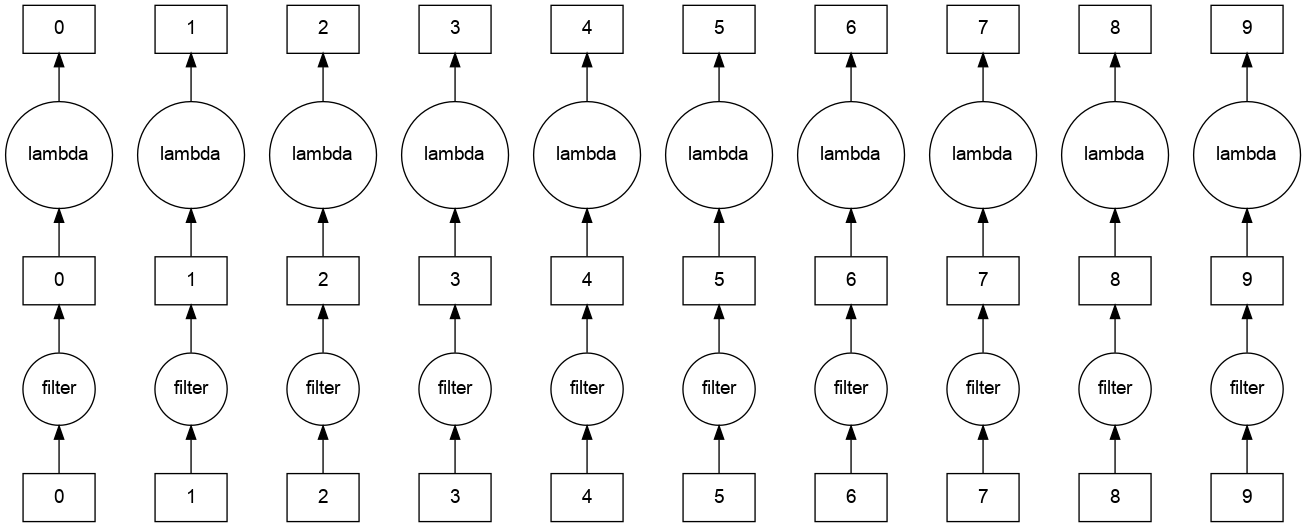

In [23]:
def is_even(n):
    return n % 2 == 0

b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
c = b.filter(is_even).map(lambda x: x ** 2)
print(c)
c.visualize()

In [8]:
# blocking form: wait for completion (which is very fast in this case)
c.compute()

[4, 16, 36, 64, 100]

### Example: Accounts JSON data

We've created a fake dataset of gzipped JSON data in your data directory.  This is like the example used in the `DataFrame` example we will see later, except that it has bundled up all of the entries for each individual `id` into a single record.  This is similar to data that you might collect off of a document store database or a web API.

Each line is a JSON encoded dictionary with the following keys

*  id: Unique identifier of the customer
*  name: Name of the customer
*  transactions: List of `transaction-id`, `amount` pairs, one for each transaction for the customer in that file

In [24]:
filename = os.path.join('data', 'accounts.*.json.gz')
lines = db.read_text(filename)
lines.take(3)

('{"id": 0, "name": "Jerry", "transactions": [{"transaction-id": 1322, "amount": 337}, {"transaction-id": 1373, "amount": 75}, {"transaction-id": 1898, "amount": 339}, {"transaction-id": 5526, "amount": 58}, {"transaction-id": 5912, "amount": 412}, {"transaction-id": 6600, "amount": 220}, {"transaction-id": 6797, "amount": 420}, {"transaction-id": 7230, "amount": 218}, {"transaction-id": 7249, "amount": 363}, {"transaction-id": 9489, "amount": 109}, {"transaction-id": 12207, "amount": 462}, {"transaction-id": 13113, "amount": 395}, {"transaction-id": 13622, "amount": 317}, {"transaction-id": 14389, "amount": 322}, {"transaction-id": 15365, "amount": 201}, {"transaction-id": 16744, "amount": 471}, {"transaction-id": 16918, "amount": 339}, {"transaction-id": 17767, "amount": 399}, {"transaction-id": 18343, "amount": 313}, {"transaction-id": 18674, "amount": 406}, {"transaction-id": 20069, "amount": 451}, {"transaction-id": 20229, "amount": 249}, {"transaction-id": 24528, "amount": 271}, 

Our data comes out of the file as lines of text. Notice that file decompression happened automatically. We can make this data look more reasonable by mapping the `json.loads` function onto our bag.

In [25]:
import json
js = lines.map(json.loads)
# take: inspect first few elements
js.take(3)

({'id': 0,
  'name': 'Jerry',
  'transactions': [{'transaction-id': 1322, 'amount': 337},
   {'transaction-id': 1373, 'amount': 75},
   {'transaction-id': 1898, 'amount': 339},
   {'transaction-id': 5526, 'amount': 58},
   {'transaction-id': 5912, 'amount': 412},
   {'transaction-id': 6600, 'amount': 220},
   {'transaction-id': 6797, 'amount': 420},
   {'transaction-id': 7230, 'amount': 218},
   {'transaction-id': 7249, 'amount': 363},
   {'transaction-id': 9489, 'amount': 109},
   {'transaction-id': 12207, 'amount': 462},
   {'transaction-id': 13113, 'amount': 395},
   {'transaction-id': 13622, 'amount': 317},
   {'transaction-id': 14389, 'amount': 322},
   {'transaction-id': 15365, 'amount': 201},
   {'transaction-id': 16744, 'amount': 471},
   {'transaction-id': 16918, 'amount': 339},
   {'transaction-id': 17767, 'amount': 399},
   {'transaction-id': 18343, 'amount': 313},
   {'transaction-id': 18674, 'amount': 406},
   {'transaction-id': 20069, 'amount': 451},
   {'transaction-id':

### Basic Queries

Once we parse our JSON data into proper Python objects (`dict`s, `list`s, etc.) we can perform more interesting queries by creating small Python functions to run on our data.

- Getting data like `filter`, `map`, don't need `compute()`.
- Calculating like `mean()`, `len` needs `compute()`.

In [26]:
# filter: keep only some elements of the sequence
js.filter(lambda record: record['name'] == 'Alice').take(5)

({'id': 114,
  'name': 'Alice',
  'transactions': [{'transaction-id': 475, 'amount': 380},
   {'transaction-id': 1060, 'amount': 470},
   {'transaction-id': 1086, 'amount': 515},
   {'transaction-id': 1637, 'amount': 470},
   {'transaction-id': 2644, 'amount': 685},
   {'transaction-id': 3046, 'amount': 469},
   {'transaction-id': 3061, 'amount': 477},
   {'transaction-id': 3114, 'amount': 404},
   {'transaction-id': 6627, 'amount': 471},
   {'transaction-id': 7254, 'amount': 400},
   {'transaction-id': 7927, 'amount': 535},
   {'transaction-id': 10144, 'amount': 493},
   {'transaction-id': 10160, 'amount': 474},
   {'transaction-id': 10667, 'amount': 321},
   {'transaction-id': 11439, 'amount': 488},
   {'transaction-id': 13114, 'amount': 354},
   {'transaction-id': 13375, 'amount': 475},
   {'transaction-id': 14249, 'amount': 497},
   {'transaction-id': 14949, 'amount': 427},
   {'transaction-id': 16872, 'amount': 394},
   {'transaction-id': 17377, 'amount': 432},
   {'transaction-id

In [27]:
def count_transactions(d):
    return {'name': d['name'], 'count': len(d['transactions'])}

# map: apply a function to each element
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .take(5))

({'name': 'Alice', 'count': 151},
 {'name': 'Alice', 'count': 145},
 {'name': 'Alice', 'count': 493},
 {'name': 'Alice', 'count': 56},
 {'name': 'Alice', 'count': 24})

In [28]:
# pluck: select a field, as from a dictionary, element[field]
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .take(5))

(151, 145, 493, 56, 24)

In [29]:
# Average number of transactions for all of the Alice entries
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .mean()
   .compute())

215.4611111111111

### Use `flatten` to de-nest

In the example below we see the use of `.flatten()` to flatten results.  We compute the average amount for all transactions for all Alices.

In [44]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')       # "plunk" gives a nested result because of the input, [ element1, element2, ...]
   .take(3))

([{'transaction-id': 475, 'amount': 380},
  {'transaction-id': 1060, 'amount': 470},
  {'transaction-id': 1086, 'amount': 515},
  {'transaction-id': 1637, 'amount': 470},
  {'transaction-id': 2644, 'amount': 685},
  {'transaction-id': 3046, 'amount': 469},
  {'transaction-id': 3061, 'amount': 477},
  {'transaction-id': 3114, 'amount': 404},
  {'transaction-id': 6627, 'amount': 471},
  {'transaction-id': 7254, 'amount': 400},
  {'transaction-id': 7927, 'amount': 535},
  {'transaction-id': 10144, 'amount': 493},
  {'transaction-id': 10160, 'amount': 474},
  {'transaction-id': 10667, 'amount': 321},
  {'transaction-id': 11439, 'amount': 488},
  {'transaction-id': 13114, 'amount': 354},
  {'transaction-id': 13375, 'amount': 475},
  {'transaction-id': 14249, 'amount': 497},
  {'transaction-id': 14949, 'amount': 427},
  {'transaction-id': 16872, 'amount': 394},
  {'transaction-id': 17377, 'amount': 432},
  {'transaction-id': 17831, 'amount': 472},
  {'transaction-id': 18033, 'amount': 509},


In [45]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()                                             # de-nest the results given by "plunk".
   .take(3))

({'transaction-id': 475, 'amount': 380},
 {'transaction-id': 1060, 'amount': 470},
 {'transaction-id': 1086, 'amount': 515})

In [46]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .pluck('amount')
   .take(3))

(380, 470, 515)

In [33]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .pluck('amount')
   .mean()
   .compute())

1944.3663460794678

### Groupby and Foldby

Often we want to group data by some function or key.  We can do this either with the `.groupby` method, which is straightforward but forces a full shuffle of the data (expensive) or with the harder-to-use but faster `.foldby` method, which does a streaming combined groupby and reduction.

*  `groupby`:  Shuffles data so that all items with the same key are in the same key-value pair
*  `foldby`:  Walks through the data accumulating a result per key

*Note: the full groupby is particularly bad. In actual workloads you would do well to use `foldby` or switch to `DataFrame`s if possible.*

### `groupby`

Groupby collects items in your collection so that all items with the same value under some function are collected together into a key-value pair.

In [34]:
b = db.from_sequence(['Alice', 'Bob', 'Charlie', 'Dan', 'Edith', 'Frank'])
b.groupby(len).compute()  # names grouped by length

[(7, ['Charlie']), (3, ['Bob', 'Dan']), (5, ['Alice', 'Edith', 'Frank'])]

In [35]:
b = db.from_sequence(list(range(10)))
b.groupby(lambda x: x % 2).compute()

[(0, [0, 2, 4, 6, 8]), (1, [1, 3, 5, 7, 9])]

In [36]:
b.groupby(lambda x: x % 2).starmap(lambda k, v: (k, max(v))).compute()

[(0, 8), (1, 9)]

### `foldby`

Foldby can be quite odd at first.  It is similar to the following functions from other libraries:

*  [`toolz.reduceby`](http://toolz.readthedocs.io/en/latest/streaming-analytics.html#streaming-split-apply-combine)
*  [`pyspark.RDD.combineByKey`](http://abshinn.github.io/python/apache-spark/2014/10/11/using-combinebykey-in-apache-spark/)

When using `foldby` you provide 

1.  A key function on which to group elements
2.  A binary operator such as you would pass to `reduce` that you use to perform reduction per each group
3.  A combine binary operator that can combine the results of two `reduce` calls on different parts of your dataset.

Your reduction must be associative.  It will happen in parallel in each of the partitions of your dataset.  Then all of these intermediate results will be combined by the `combine` binary operator.

In [37]:
# foldby:   key function, binary op, combine binary op
b.foldby(lambda x: x % 2, binop=max, combine=max).compute()    # binop: binary operator

[(0, 8), (1, 9)]

### Example with account data

We find the number of people with the same name.

In [41]:
%%time
# Warning, this one takes a while...
result = js.groupby(lambda item: item['name']).starmap(lambda k, v: (k, len(v))).compute()
print(sorted(result))

[('Alice', 216), ('Alice', 216), ('Alice', 216), ('Alice', 252), ('Bob', 240), ('Bob', 240), ('Bob', 240), ('Bob', 277), ('Charlie', 240), ('Charlie', 240), ('Charlie', 240), ('Charlie', 280), ('Dan', 283), ('Dan', 285), ('Dan', 285), ('Dan', 332), ('Edith', 228), ('Edith', 228), ('Edith', 228), ('Edith', 266), ('Frank', 210), ('Frank', 210), ('Frank', 210), ('Frank', 249), ('George', 204), ('George', 204), ('George', 204), ('George', 238), ('Hannah', 227), ('Hannah', 228), ('Hannah', 228), ('Hannah', 265), ('Ingrid', 192), ('Ingrid', 192), ('Ingrid', 192), ('Ingrid', 224), ('Jerry', 204), ('Jerry', 204), ('Jerry', 204), ('Jerry', 237), ('Kevin', 372), ('Kevin', 372), ('Kevin', 372), ('Kevin', 434), ('Laura', 276), ('Laura', 276), ('Laura', 276), ('Laura', 322), ('Michael', 228), ('Michael', 228), ('Michael', 228), ('Michael', 266), ('Norbert', 228), ('Norbert', 228), ('Norbert', 228), ('Norbert', 265), ('Oliver', 252), ('Oliver', 252), ('Oliver', 252), ('Oliver', 294), ('Patricia', 21

In [77]:
%%time
# This one is comparatively fast and produces the same result.
from operator import add
def incr(tot, _):
    return tot + 1

result = js.foldby(key='name', 
                   binop=incr,                       # Combine two object
                   initial=0, 
                   combine=add,                      # Combine two results from combination of two objects using smallf.
                   combine_initial=0).compute()
print(sorted(result))

[('Alice', 900), ('Bob', 997), ('Charlie', 1000), ('Dan', 1185), ('Edith', 950), ('Frank', 879), ('George', 850), ('Hannah', 948), ('Ingrid', 800), ('Jerry', 849), ('Kevin', 1550), ('Laura', 1150), ('Michael', 950), ('Norbert', 949), ('Oliver', 1050), ('Patricia', 900), ('Quinn', 700), ('Ray', 900), ('Sarah', 892), ('Tim', 1000), ('Ursula', 792), ('Victor', 950), ('Wendy', 900), ('Xavier', 898), ('Yvonne', 950), ('Zelda', 1048)]
CPU times: user 23.4 ms, sys: 168 ms, total: 192 ms
Wall time: 930 ms


### Exercise: compute total amount per name

We want to groupby (or foldby) the `name` key, then add up the all of the amounts for each name.

Steps

1.  Create a small function that, given a dictionary like 

        {'name': 'Alice', 'transactions': [{'amount': 1, 'id': 123}, {'amount': 2, 'id': 456}]}
        
    produces the sum of the amounts, e.g. `3`
    
2.  Slightly change the binary operator of the `foldby` example above so that the binary operator doesn't count the number of entries, but instead accumulates the sum of the amounts.

In [78]:
%%time
# Answer...
# I guess dict and list object do not have methods like "plunk", "flatten", ...
from operator import add

def smallf(dic):
    sum_amt = sum([i['amount'] for i in dic['transactions']])
    return sum_amt

def incr(tot, dic):
    return tot + smallf(dic)
    
result = js.foldby(key='name',
                   binop=incr,                     # Combine two object
                   initial=0,
                   combine=add,                    # Combine two results from combination of two objects using smallf.
                   combine_initial=0).compute()
result

CPU times: user 44.1 ms, sys: 153 ms, total: 197 ms
Wall time: 951 ms


[('Jerry', 97662376),
 ('Hannah', 239281842),
 ('Ray', -4008567),
 ('Dan', 193186147),
 ('Michael', 343608073),
 ('Kevin', 301048505),
 ('Quinn', 168902204),
 ('Victor', 23824177),
 ('Xavier', 251071979),
 ('Zelda', 122298177),
 ('Patricia', 541461596),
 ('Wendy', 109341012),
 ('George', 134605220),
 ('Yvonne', 154683456),
 ('Frank', 41783793),
 ('Norbert', 52425010),
 ('Ingrid', 200013657),
 ('Oliver', 242065834),
 ('Laura', 109088230),
 ('Ursula', 153488317),
 ('Bob', 89104400),
 ('Edith', 192612915),
 ('Tim', 289416807),
 ('Charlie', 316981140),
 ('Sarah', 57624997),
 ('Alice', 377041800)]

## DataFrames

For the same reasons that Pandas is often faster than pure Python, `dask.dataframe` can be faster than `dask.bag`.  We will work more with DataFrames later, but from the point of view of a Bag, it is frequently the end-point of the "messy" part of data ingestion—once the data can be made into a data-frame, then complex split-apply-combine logic will become much more straight-forward and efficient.

You can transform a bag with a simple tuple or flat dictionary structure into a `dask.dataframe` with the `to_dataframe` method.

In [64]:
df1 = js.to_dataframe()
df1.head()

,id,name,transactions
0,0,Jerry,"[{'transaction-id': 1322, 'amount': 337}, {'tr..."
1,1,Hannah,"[{'transaction-id': 509, 'amount': -253}, {'tr..."
2,2,Jerry,"[{'transaction-id': 10671, 'amount': 1618}, {'..."
3,3,Jerry,"[{'transaction-id': 1867, 'amount': 9}, {'tran..."
4,4,Ray,"[{'transaction-id': 55, 'amount': -1776}, {'tr..."


This now looks like a well-defined DataFrame, and we can apply Pandas-like computations to it efficiently.

Using a Dask DataFrame, how long does it take to do our prior computation of numbers of people with the same name?  It turns out that `dask.dataframe.groupby()` beats `dask.bag.groupby()` by more than an order of magnitude; but it still cannot match `dask.bag.foldby()` for this case.

In [68]:
%time df1.groupby('name').id.count().compute().head()

CPU times: user 6.94 s, sys: 526 ms, total: 7.47 s
Wall time: 6.28 s


name
Alice       900
Bob         997
Charlie    1000
Dan        1185
Edith       950
Name: id, dtype: int64

### Denormalization

This DataFrame format is less-than-optimal because the `transactions` column is filled with nested data so Pandas has to revert to `object` dtype, which is quite slow in Pandas.  Ideally we want to transform to a dataframe only after we have flattened our data so that each record is a single `int`, `string`, `float`, etc..

In [57]:
def denormalize(record):
    # returns a list for each person, one item per transaction
    return [{'id': record['id'], 
             'name': record['name'], 
             'amount': transaction['amount'], 
             'transaction-id': transaction['transaction-id']}
            for transaction in record['transactions']]

transactions = js.map(denormalize).flatten()
transactions.take(3)

({'id': 0, 'name': 'Jerry', 'amount': 337, 'transaction-id': 1322},
 {'id': 0, 'name': 'Jerry', 'amount': 75, 'transaction-id': 1373},
 {'id': 0, 'name': 'Jerry', 'amount': 339, 'transaction-id': 1898})

In [58]:
df = transactions.to_dataframe()
df.head()

,id,name,amount,transaction-id
0,0,Jerry,337,1322
1,0,Jerry,75,1373
2,0,Jerry,339,1898
3,0,Jerry,58,5526
4,0,Jerry,412,5912


In [61]:
%%time
# number of transactions per name
# note that the time here includes the data load and ingestion
df.groupby('name')['transaction-id'].count().compute()

CPU times: user 269 ms, sys: 16.1 ms, total: 285 ms
Wall time: 3.26 s


name
Alice       193915
Bob         141187
Charlie     254007
Dan         178282
Edith       193305
Frank       197877
George      110549
Hannah      178634
Ingrid      213318
Jerry       131521
Kevin       283675
Laura       196301
Michael     181450
Norbert     109894
Oliver      202552
Patricia    225612
Quinn       133797
Ray         163701
Sarah       175272
Tim         295563
Ursula      276039
Victor      193829
Wendy       202857
Xavier      212367
Yvonne      208695
Zelda       145801
Name: transaction-id, dtype: int64

## Limitations

Bags provide very general computation (any Python function.)  This generality
comes at cost.  Bags have the following known limitations

1.  Bag operations tend to be slower than array/dataframe computations in the
    same way that Python tends to be slower than NumPy/Pandas
2.  ``Bag.groupby`` is slow.  You should try to use ``Bag.foldby`` if possible.
    Using ``Bag.foldby`` requires more thought. Even better, consider creating
    a normalised dataframe.

## Learn More

* [Bag documentation](https://docs.dask.org/en/latest/bag.html)
* [Bag screencast](https://youtu.be/-qIiJ1XtSv0)
* [Bag API](https://docs.dask.org/en/latest/bag-api.html)
* [Bag examples](https://examples.dask.org/bag.html)

## Shutdown

In [62]:
client.shutdown()

2022-05-23 16:56:25,235 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
